Practice code snippet for assgnment-1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.nn.init as init
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [ ]:
from PIL import Image, ImageEnhance, ImageOps
import random
import numpy as np
import torch


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        self.p1 = p1
        self.op1=operation1
        self.magnitude_idx1=magnitude_idx1
        self.p2 = p2
        self.op2=operation2
        self.magnitude_idx2=magnitude_idx2
        self.fillcolor=fillcolor
        self.init = 0

    def gen(self, operation1, magnitude_idx1, operation2, magnitude_idx2, fillcolor):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude *
                                         random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude *
                                         random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude *
                                         img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude *
                                         img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if self.init == 0:
            self.gen(self.op1, self.magnitude_idx1, self.op2, self.magnitude_idx2, self.fillcolor)
            self.init = 1
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """

    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"

class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.

        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """

    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.8, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


In [ ]:
def GetCifar10(batchsize):
    trans_t = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  # CIFAR10Policy(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                  Cutout(n_holes=1, length=16)
                                  ])
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    train_data = datasets.CIFAR10('./data', train=True, transform=trans_t, download=True)
    test_data = datasets.CIFAR10('./data', train=False, transform=trans, download=True)
    train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=8)
    test_dataloader = DataLoader(test_data, batch_size=batchsize, shuffle=False, num_workers=8)
    return train_dataloader, test_dataloader

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(128, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))  # fixed output size
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def vgg(cfg, num_classes=10, batch_norm=True):
    return VGG(make_layers(cfg, batch_norm=batch_norm), num_classes=num_classes)

# VGG-6 configuration
cfg_vgg6 = [64, 64, 'M', 128, 128, 'M']

model = vgg(cfg_vgg6, num_classes=10, batch_norm=True)
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Seque

In [ ]:
def eval(model,data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    acc = 100. * correct / total
    return acc

In [ ]:
train_loader,test_loader = GetCifar10(64)

100%|██████████| 170M/170M [00:03<00:00, 47.1MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = vgg(cfg_vgg6, num_classes=10, batch_norm=True).to(device)

criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
def train_model(model,epochs,optimizer,train_loader,test_loader):

    model.train()
    for epoch in range(epochs):
      running_loss = 0.0
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          outputs = model(data)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      train_acc = eval(model,train_loader)
      test_acc = eval(model,test_loader)
      print(f"Epoch {epoch} - Train_Loss: {running_loss/len(train_loader):.4f} , Train_acc: {train_acc}, Test_acc : {test_acc}")

In [ ]:
train_model(model,10,optimizer,train_loader,test_loader)

Epoch 0 - Train_Loss: 1.5141 , Train_acc: 47.778, Test_acc : 51.8
Epoch 1 - Train_Loss: 1.3501 , Train_acc: 56.022, Test_acc : 58.28
Epoch 2 - Train_Loss: 1.1667 , Train_acc: 59.02, Test_acc : 63.03
Epoch 3 - Train_Loss: 1.0772 , Train_acc: 63.272, Test_acc : 65.77
Epoch 4 - Train_Loss: 0.9946 , Train_acc: 66.76, Test_acc : 68.84
Epoch 5 - Train_Loss: 0.9243 , Train_acc: 69.744, Test_acc : 71.79
Epoch 6 - Train_Loss: 0.8814 , Train_acc: 69.762, Test_acc : 71.97
Epoch 7 - Train_Loss: 0.8319 , Train_acc: 70.634, Test_acc : 73.97
Epoch 8 - Train_Loss: 0.7978 , Train_acc: 73.63, Test_acc : 76.44
Epoch 9 - Train_Loss: 0.7687 , Train_acc: 74.63, Test_acc : 76.54


Q1(a) Prepare CIFAR-10 with proper normalization and data augmentation. Specify the transforms used.

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ----- Data Augmentation and Normalization -----
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         # small random shifts
    transforms.RandomHorizontalFlip(),            # mirror augmentation
    transforms.ToTensor(),                        # convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# ----- Load CIFAR-10 -----
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Q1(B) Train the model with one chosen configuration (preferably the one that gives the best test accuracy)

Epoch [1/20] Train Acc: 42.08%  Val Acc: 56.29%
Epoch [2/20] Train Acc: 58.46%  Val Acc: 67.04%
Epoch [3/20] Train Acc: 65.30%  Val Acc: 70.76%
Epoch [4/20] Train Acc: 69.37%  Val Acc: 73.43%
Epoch [5/20] Train Acc: 72.07%  Val Acc: 75.93%
Epoch [6/20] Train Acc: 73.91%  Val Acc: 75.87%
Epoch [7/20] Train Acc: 75.46%  Val Acc: 76.72%
Epoch [8/20] Train Acc: 76.25%  Val Acc: 78.35%
Epoch [9/20] Train Acc: 77.54%  Val Acc: 78.58%
Epoch [10/20] Train Acc: 78.50%  Val Acc: 79.70%
Epoch [11/20] Train Acc: 79.12%  Val Acc: 80.65%
Epoch [12/20] Train Acc: 79.81%  Val Acc: 80.99%
Epoch [13/20] Train Acc: 80.46%  Val Acc: 80.81%
Epoch [14/20] Train Acc: 80.62%  Val Acc: 81.52%
Epoch [15/20] Train Acc: 81.42%  Val Acc: 80.96%
Epoch [16/20] Train Acc: 81.72%  Val Acc: 81.71%
Epoch [17/20] Train Acc: 82.06%  Val Acc: 82.62%
Epoch [18/20] Train Acc: 82.78%  Val Acc: 82.27%
Epoch [19/20] Train Acc: 83.22%  Val Acc: 82.60%
Epoch [20/20] Train Acc: 83.05%  Val Acc: 82.98%


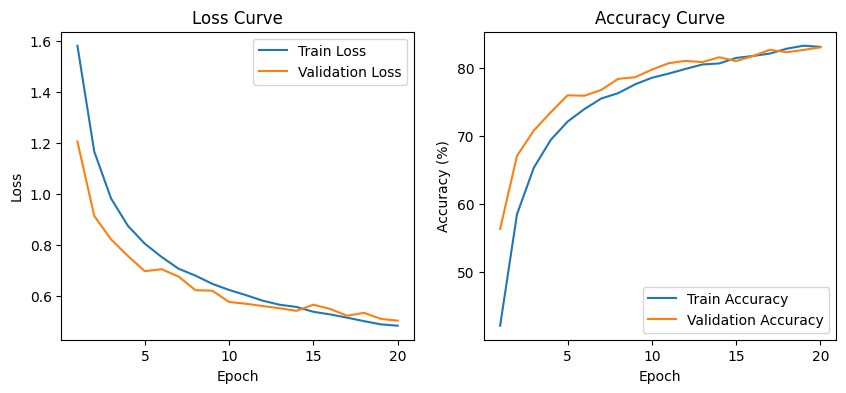

In [ ]:
# ============================================
# CS6886W - System Engineering for Deep Learning
# Assignment 1(b): Train baseline VGG6 on CIFAR-10
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data preparation ---
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# --- 2. Define VGG6 model ---
class VGG6(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG6, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- 3. Training configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG6().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []

# --- 4. Training loop ---
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100 * correct / total
    train_loss = running_loss / len(trainloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100 * correct / total
    val_loss /= len(testloader)

    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.2f}%  Val Acc: {val_acc:.2f}%")

# --- 5. Plot learning curves ---
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.show()


Q1(c) Report the final test top-1 accuracy and include loss/accuracy curves.

In [6]:
# After training
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.show()


NameError: name 'plt' is not defined

Q2(a). Model Performance on Different Configurations (60 points)
 (a) Vary the activation function. Use different activations such as ReLU, Sigmoid, Tanh,SiLU, GELU, etc. Describe how model performance changes when the activation function is varied.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ----- Dataset -----
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

# ----- VGG6 model with variable activation -----
class VGG6(nn.Module):
    def __init__(self, activation_fn):
        super(VGG6, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), activation_fn(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), activation_fn(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), activation_fn(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512), activation_fn(), nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# ----- Evaluation function -----
def train_and_eval(act_fn, act_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VGG6(act_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 20

    for epoch in range(epochs):
        model.train()
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(imgs), labels)
            loss.backward()
            optimizer.step()

    # Evaluate accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
    acc = 100 * correct / total
    print(f"{act_name} Accuracy: {acc:.2f}%")
    return acc

# ----- Run experiments -----
activations = {
    "ReLU": nn.ReLU,
    "Sigmoid": nn.Sigmoid,
    "Tanh": nn.Tanh,
    "SiLU": nn.SiLU,
    "GELU": nn.GELU
}

results = {name: train_and_eval(fn, name) for name, fn in activations.items()}
print(results)


ReLU Accuracy: 81.82%
Sigmoid Accuracy: 72.20%
Tanh Accuracy: 77.14%
SiLU Accuracy: 85.09%
GELU Accuracy: 84.71%
{'ReLU': 81.82, 'Sigmoid': 72.2, 'Tanh': 77.14, 'SiLU': 85.09, 'GELU': 84.71}


Q2(b) Vary the optimizer. Use different optimizers such as SGD, Nesterov-SGD, Adam,
 Adagrad, RMSprop, Nadam, etc. Explain how each optimizer affects convergence and how they differ from one another.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ----- Dataset -----
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

# ----- VGG6 model -----
class VGG6(nn.Module):
    def __init__(self):
        super(VGG6, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# ----- Evaluation function -----
def train_and_eval(optimizer_fn, name, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VGG6().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(model.parameters(), lr=lr)
    epochs = 20

    # Training
    for epoch in range(epochs):
        model.train()
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(imgs), labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
    acc = 100 * correct / total
    print(f"{name}: {acc:.2f}%")
    return acc

# ----- Run optimizers -----
optimizers = {
    "SGD": lambda p, lr: optim.SGD(p, lr=lr),
    "Nesterov-SGD": lambda p, lr: optim.SGD(p, lr=lr, momentum=0.9, nesterov=True),
    "Adam": lambda p, lr: optim.Adam(p, lr=lr),
    "Adagrad": lambda p, lr: optim.Adagrad(p, lr=lr),
    "RMSprop": lambda p, lr: optim.RMSprop(p, lr=lr),
    "Nadam": lambda p, lr: optim.NAdam(p, lr=lr)
}

results = {}
for name, opt_fn in optimizers.items():
    lr = 0.01 if "SGD" in name else 0.001
    results[name] = train_and_eval(opt_fn, name, lr)

print(results)


100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


SGD: 64.85%
Nesterov-SGD: 83.79%
Adam: 81.96%
Adagrad: 62.15%
RMSprop: 81.34%
Nadam: 83.67%
{'SGD': 64.85, 'Nesterov-SGD': 83.79, 'Adam': 81.96, 'Adagrad': 62.15, 'RMSprop': 81.34, 'Nadam': 83.67}


 Q2(c) Vary the batch size, number of epochs, and learning rate. Explain how the convergence speed and performance vary with these changes.

In [ ]:
# Sweep runner for batch size / epochs / lr experiments (PyTorch)
import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time, itertools, json
import numpy as np

# Basic VGG6 (same as earlier)
class VGG6(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1), activation(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), activation(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), activation(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4,512), activation(), nn.Dropout(0.5),
            nn.Linear(512,10)
        )
    def forward(self,x): return self.classifier(self.features(x))

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate_config(batch_size=128, epochs=20, lr=1e-3, optimizer_name='Adam', seed=42):
    torch.manual_seed(seed); np.random.seed(seed)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2)

    model = VGG6().to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("add more optimizers as needed")

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()
    for ep in range(epochs):
        model.train()
        running_loss=0.0; correct=0; total=0
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0); correct += preds.eq(labels).sum().item()

        train_losses.append(running_loss/len(trainloader))
        train_accs.append(100.*correct/total)

        # validation
        model.eval()
        vloss=0.0; correct=0; total=0
        with torch.no_grad():
            for imgs, labels in testloader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                vloss += loss.item()
                _, preds = outputs.max(1)
                total += labels.size(0); correct += preds.eq(labels).sum().item()
        val_losses.append(vloss/len(testloader))
        val_accs.append(100.*correct/total)

    elapsed = time.time() - start_time
    result = {
        "batch_size": batch_size,
        "epochs": epochs,
        "lr": lr,
        "optimizer": optimizer_name,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "val_acc_best": max(val_accs),
        "val_acc_last": val_accs[-1],
        "time_sec": elapsed
    }
    return result

# Example sweep grid
batch_sizes = [32, 64, 128, 256]
epochs_list = [20, 50]
lrs_adam = [1e-4, 5e-4, 1e-3, 2e-3]
configs = []
for b, e, lr in itertools.product(batch_sizes, epochs_list, lrs_adam):
    configs.append((b,e,lr))

# WARNING: Running all configs is time-consuming. Here is how to run one example:
res = evaluate_config(batch_size=128, epochs=20, lr=1e-3, optimizer_name='Adam')
print(res['val_acc_best'])

# To run multiple configs:
# all_results = []
# for (b,e,lr) in configs:
#     r = evaluate_config(batch_size=b, epochs=e, lr=lr, optimizer_name='Adam')
#     all_results.append(r)
#     # optionally save to disk
#     with open(f"result_b{b}_e{e}_lr{lr}.json","w") as f:
#         json.dump(r, f)


81.6


In [ ]:
pip install wandb


In [ ]:
import wandb
wandb.login()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: purnanayak024 (purnanayak024-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True